In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Create Masks


Use the already stacked data for each resolution group to create masked arrays.


In [43]:
import os
import rasterio
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
from config import raw_data_dir, processed_data_dir

from rasterio.plot import show

%matplotlib inline

# Test dir
date = '2017-01-31'
images_dir ='../data/interim/res-groups/'

img_dir = img_dir = os.path.join(images_dir, date)

out_dir = os.path.join(processed_data_dir, 'data_v2', date)

if not os.path.isdir(out_dir):
    os.makedirs(out_dir)

    
res_groups = [60, 20, 10]

fpaths = {grp: os.path.join(img_dir, f'{grp}.jp2') for grp in res_groups}


# Dimensions to zero-pad images to
MAX_DIMS = {
    '10': (90, 90),
    '20': (50, 50),
    '60': (20, 20)
}

## Read Shapefile

In [44]:
from src.utils import read_shapefile

train_shp_df = read_shapefile('train')

## Read Raster

In [45]:
fpaths

{60: '../data/interim/res-groups/2017-01-31/60.jp2',
 20: '../data/interim/res-groups/2017-01-31/20.jp2',
 10: '../data/interim/res-groups/2017-01-31/10.jp2'}

In [46]:
res_group = 10
fp = fpaths[res_group]
raster = rasterio.open(fp)

## Inspect the raster

In [47]:
raster.count

4

In [49]:
x = raster.read(1)

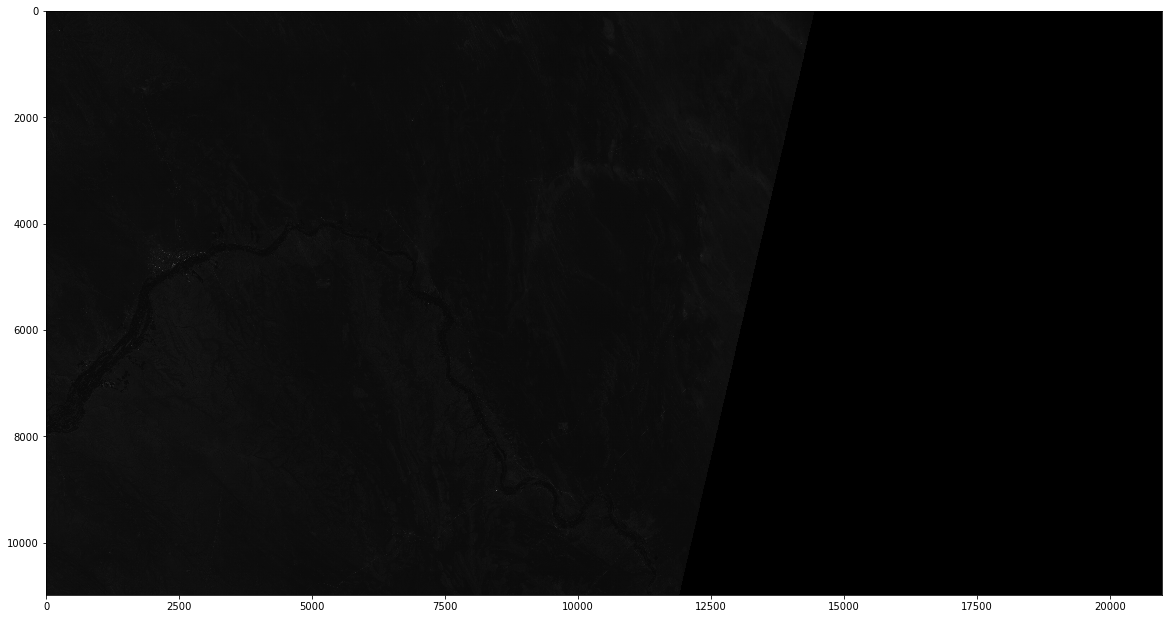

In [50]:
plt.figure(figsize=(20,20))
plt.imshow(x, cmap='gray')

### Approach

1. Create mask array for all farms on the entire raster
 - ie create a boolean mask array of the same shape of the raster which is 1 where farms are present in pixels.
2. Get window of desired shape containing farm shape and surrounding data
3. Read image data of window
4. Read mask data of window
5. Combine image and mask data into one array with multiple channels

In [51]:
import rasterio
from rasterio.mask import raster_geometry_mask

def get_mask_window(shape, raster, max_dims=None):
    
    # Get the boolean mask and window of shape
    try:
        bool_mask, transform, bb_window = raster_geometry_mask(raster, [shape], crop=True)
    except ValueError:
        return None
    
    if max_dims is  None:
        return bb_window
    else:
        # Turn mask into int array with 1 at farm pixels
        int_mask = np.bitwise_not(bool_mask).astype(int)

        # Get the shape of the bounding box window
        bb_shape = (bb_window.height, bb_window.width)


        # Get number of pixels to add to x and y dims
        pad_x = int(np.ceil((max_dims[1]-bb_shape[1])/2))
        pad_y = int(np.ceil((max_dims[0]-bb_shape[0])/2))

        # Get a window with padding around it and the desired shape in the center
        # Depending on the shape, this window can be a different size than max_dims
        window_ = rasterio.mask.geometry_window(raster, 
                                                      [shape], 
                                                      pad_x=pad_x, 
                                                      pad_y=pad_y, 
                                                      pixel_precision=2 # I found this fixes some rounding errors
                                                     )

        # To fix sizing issues, create a new window that starts at the same top left anchor, but of a fixed width and height
        window = rasterio.windows.Window(col_off=window_.col_off, row_off=window_.row_off, width=max_dims[1], height=max_dims[0])
    
        return window
    
    
def get_farm_data(masked_raster, raster, farm_shape, out_shape):
    
    bands = raster.count
    
    # The window defining where on the raster this shape is found
    mask_window = get_mask_window(farm_shape, raster, max_dims=None)
    
    if mask_window is None:
        return 0.
    
    # The same window, but padded to the desired dims
    mask_window_padded = get_mask_window(farm_shape, raster, max_dims=out_shape)

    # Crop out the image data around the shape 
    win_img = raster.read(window=mask_window_padded)

    # Crop out the boolean mask of all farms in the window around the farm of interest
    win_mask_other = masked_raster[mask_window_padded.row_off:mask_window_padded.row_off+out_shape[0], 
                                   mask_window_padded.col_off:mask_window_padded.col_off+out_shape[1]]
    
    temp = np.copy(masked_raster)

    temp[:mask_window.row_off,:] = False
    temp[mask_window.row_off+mask_window.width:,:]=False
    temp[:,:mask_window.col_off] = False
    temp[:,mask_window.col_off+mask_window.height:]=False

    win_mask_farm = temp[mask_window_padded.row_off:mask_window_padded.row_off+out_shape[0], 
                         mask_window_padded.col_off:mask_window_padded.col_off+out_shape[1]]

    del temp

    
    data = np.zeros((bands+2, *out_shape))
    data[:bands] = win_img
    data[-2] = win_mask_other
    data[-1] = win_mask_farm
    
    return data

Resolution Group:  10
Output Shape (90, 90)
Farm shape:


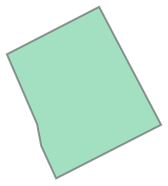

In [52]:
out_shape = MAX_DIMS[str(res_group)]

print('Resolution Group: ',res_group)
print('Output Shape', out_shape)

farm_shapes = train_shp_df.geometry.to_list()

# Get an boolean mask array with all farms in it
masked_raster, _, _  = rasterio.mask.raster_geometry_mask(raster, farm_shapes, invert=True)

farm_id = 368
farm_shape = train_shp_df.geometry.iloc[farm_id]

print('Farm shape:')
display(farm_shape)

In [53]:
%%time
data = get_farm_data(masked_raster, raster, farm_shape, out_shape)

CPU times: user 949 ms, sys: 205 ms, total: 1.15 s
Wall time: 226 ms


Data Shape: (6, 90, 90)


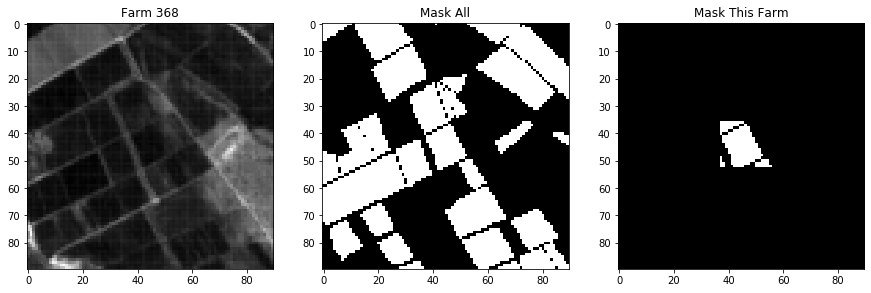

In [54]:
fig, axes = plt.subplots(1, 3, figsize=(15,15))

print("Data Shape:", data.shape)

ax=axes[0]
ax.imshow(data[0], cmap='gray')
ax.set_title('Farm {}'.format(farm_id))

ax=axes[1]
ax.imshow(data[-2], cmap='gray')
ax.set_title('Mask All')

ax=axes[2]
ax.imshow(data[-1], cmap='gray')
ax.set_title('Mask This Farm');

In [41]:
from tqdm import tqdm


def get_farms_data(farm_shapes, raster, out_shape):
    """
    
    """
    
     # Get an boolean mask array with all farms in it
    masked_raster, _, _  = rasterio.mask.raster_geometry_mask(raster, farm_shapes.geometry.to_list(), invert=True)
    
    all_data = {}
    
    for id, shape in tqdm(farm_shapes.iteritems()):
        farm_data = get_farm_data(masked_raster, raster, shape, out_shape)
        
        if type(farm_data) == np.ndarray:
            all_data[id] = farm_data
        
    return all_data
        

## Get farm data for all farms

In [42]:
farm_shapes = train_shp_df.geometry

with rasterio.open(fp) as raster:
    farms_data = get_farms_data(farm_shapes, raster, out_shape)

2494it [01:18, 25.64it/s]


### Show image and mask data of 3 random farms

In [ ]:
choices = np.random.choice(list(farms_data.keys()), (3,))

for i, random_farm_id in enumerate(choices):
    
    fig, axes = plt.subplots(1, 3, figsize=(10,15))
    
    display(farm_shapes[random_farm_id])
    
    farm_data = farms_data[random_farm_id]
    
    ax=axes[0]
    ax.imshow(farm_data[0], cmap='gray')
    ax.set_title('Farm {}'.format(farm_id))

    ax=axes[1]
    ax.imshow(farm_data[1], cmap='gray')
    ax.set_title('Mask All')

    ax=axes[2]
    ax.imshow(farm_data[2], cmap='gray')
    ax.set_title('Mask This Farm')
    
    plt.show()

## Save data

In [ ]:
for farm_id, data in tqdm(farms_data.items()):
    out_fp = os.path.join(out_dir, f'farm_{farm_id}.npy')
    np.save(out_fp, data)

## Turn into scripts

In [ ]:
import os
import rasterio
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

from glob import glob

import sys
sys.path.append('../')
from config import raw_data_dir, processed_data_dir

import rasterio
from rasterio.mask import raster_geometry_mask

from src.utils import read_shapefile

res_groups = {
    '60': ['B01', 'B09', 'B10'],
    '20': ['B05', 'B06', 'B07', 'B8A', 'B11', 'B12'],
    '10': ['B02', 'B03', 'B04', 'B08', 'TCI']
}

# Dimensions to zero-pad images to
MAX_DIMS = {
    '10': (90, 90),
    '20': (50, 50),
    '60': (20, 20)
}

dates = ['2017-01-01','2017-02-10','2017-03-22','2017-06-20',
         '2017-07-15','2017-08-19','2017-01-31','2017-03-12',
         '2017-05-31','2017-07-10','2017-08-04']

bands = ['B01','B02','B03','B04','B05','B06','B07','B8A','B09','B10','B11','B12','TCI']


# Input images
images_dir ='../data/interim/images-merged/'

img_dir = img_dir = os.path.join(images_dir, date)

out_dir = os.path.join(processed_data_dir, 'data_v1', date)

if not os.path.isdir(out_dir):
    os.makedirs(out_dir)
    

def get_mask_window(shape, raster, max_dims=None):
    
    # Get the boolean mask and window of shape
    try:
        bool_mask, transform, bb_window = raster_geometry_mask(raster, [shape], crop=True)
    except ValueError:
        return None
    
    if max_dims is  None:
        return bb_window
    else:
        # Turn mask into int array with 1 at farm pixels
        int_mask = np.bitwise_not(bool_mask).astype(int)

        # Get the shape of the bounding box window
        bb_shape = (bb_window.height, bb_window.width)


        # Get number of pixels to add to x and y dims
        pad_x = int(np.ceil((max_dims[1]-bb_shape[1])/2))
        pad_y = int(np.ceil((max_dims[0]-bb_shape[0])/2))

        # Get a window with padding around it and the desired shape in the center
        # Depending on the shape, this window can be a different size than max_dims
        window_ = rasterio.mask.geometry_window(raster, 
                                                      [shape], 
                                                      pad_x=pad_x, 
                                                      pad_y=pad_y, 
                                                      pixel_precision=2 # I found this fixes some rounding errors
                                                     )

        # To fix sizing issues, create a new window that starts at the same top left anchor, but of a fixed width and height
        window = rasterio.windows.Window(col_off=window_.col_off, row_off=window_.row_off, width=max_dims[1], height=max_dims[0])
    
        return window
    
    
def get_farm_data(masked_raster, raster, farm_shape, out_shape):
    
    bands = raster.count
    
    # The window defining where on the raster this shape is found
    mask_window = get_mask_window(farm_shape, raster, max_dims=None)
    
    if mask_window is None:
        return 0.
    
    # The same window, but padded to the desired dims
    mask_window_padded = get_mask_window(farm_shape, raster, max_dims=out_shape)

    # Crop out the image data around the shape 
    win_img = raster.read(window=mask_window_padded)[0]

    # Crop out the boolean mask of all farms in the window around the farm of interest
    win_mask_other = masked_raster[mask_window_padded.row_off:mask_window_padded.row_off+out_shape[0], 
                                   mask_window_padded.col_off:mask_window_padded.col_off+out_shape[1]]
    
    temp = np.copy(masked_raster)

    temp[:mask_window.row_off,:] = False
    temp[mask_window.row_off+mask_window.width:,:]=False
    temp[:,:mask_window.col_off] = False
    temp[:,mask_window.col_off+mask_window.height:]=False

    win_mask_farm = temp[mask_window_padded.row_off:mask_window_padded.row_off+out_shape[0], 
                         mask_window_padded.col_off:mask_window_padded.col_off+out_shape[1]]

    del temp

    
    data = np.zeros((bands+2, *out_shape))
    data[:bands] = win_img
    data[-2] = win_mask_other
    data[-1] = win_mask_farm
    
    return data   

def get_farms_data(farm_shapes, raster, out_shape):
    """
    
    """
    
     # Get an boolean mask array with all farms in it
    masked_raster, _, _  = rasterio.mask.raster_geometry_mask(raster, farm_shapes.geometry.to_list(), invert=True)
    
    all_data = {}
    
    for id, shape in tqdm(farm_shapes.iteritems()):
        farm_data = get_farm_data(masked_raster, raster, shape, out_shape)
        
        if type(farm_data) == np.ndarray:
            all_data[id] = farm_data
        
    return all_data

In [ ]:
def extract_masks(shp_df, date):
    
    print('-'*50,date,'-'*50)
    
    shp_df = read_shapefile(dataset)
    
    farm_shapes = shp_df.geometry
    
    for band in bands:
        
        print('\tBand: ',band)
        fp = os.path.join(images_dir, date, f'{band}.jp2')
        
        [res_group] = [grp for grp, bands in res_groups.items() if band in bands]
        out_shape = MAX_DIMS[res_group]
        
        with rasterio.open(fp) as raster:
            farms_data = get_farms_data(farm_shapes, raster, out_shape)
            
        save_data(farms_data, band)


def save_data(farms_data, band):
    
    print('Saving...',end='')
    for farm_id, data in farms_data.items():
        out_fp = os.path.join(date_dir, f'farm_{farm_id}_{band}.npy')
        np.save(out_fp, data)
    print('done')



for dataset in ['train','test']:
    
    print('-'*50,dataset,'-'*50)
    
    # create dir
    dataset_dir = os.path.join(out_dir, dataset)
    
    if not os.path.isdir(dataset_dir):
        os.makedirs(dataset_dir)
    
    shp_df = read_shapefile(dataset)

    for date in dates:
        # create dir
        date_dir = os.path.join(dataset_dir, date)
        
        if not os.path.isdir(date_dir):
            os.makedirs(date_dir)
            
        extract_masks(shp_df, date)
        
        
    
    